In [229]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [230]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from kalman_vect import plot_2d_gauss, generate_sample, plot_update, plot_prediction

# The model

$\vec{X_{k+1}} = F\vec{X_{k}} +  B \vec{U_k} + \vec{W_k}$

$\vec{Z_k} = H\vec{X_k} + \vec{V_k}$

**$\vec{X}$**: The state vector.

**$\vec{Z}$**: The observation vector. 

**$\vec{W}$**: The process noise. Mean zero and covariance matrix $Q$: $W = N(0,Q)$

**$F$**: The state transition factor. See example below

**$B, \vec{U}$**: The control input model. B is a Matrix

**$H$**: Observation model. Maps the true state space into the observation space

**$V$**: Observation Noise. Mean zero and covariance matrix $R$: $V = N(0,R)$


# Generative model

## Walking robot example

$\vec{X} = \begin{bmatrix}x \\ \dot{x} \end{bmatrix} \quad
F = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix}\quad
H = \begin{bmatrix} 1 & 0 \end{bmatrix} \quad$

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix} = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{W}$

${Z_k} = \begin{bmatrix} 1 & 0 \end{bmatrix}\begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{V}$

$\Sigma_w = Q = \begin{bmatrix}\sigma_w^2 & 0 \\ 0 & 0 \end{bmatrix} \quad
\Sigma_v = R = \sigma_v^2 $

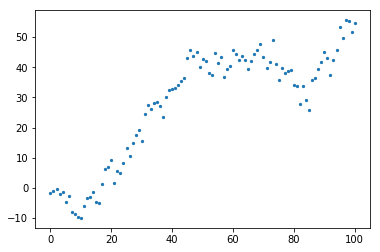

In [351]:
starting_position = 0
starting_velocity = 1
X_o = np.array([starting_position,starting_velocity]).reshape(2,1)
var_w = 10
sigma_w = np.array([[var_w,0],[0,0]])
var_v = 1
sigma_v = np.array([[var_v]])
F = np.array([[1,1],[0,1]])
H = np.array([1,0]).reshape(1,2)
B = np.array([[0,0],[0,0]])
U = np.array([0,0]).reshape(2,1)
steps = 100
measurements = generate_sample(X_o, sigma_w ,sigma_v , H, F , B, U , steps = steps)
measurements = measurements.reshape(steps+1,1)
plt.scatter(range(len(measurements)),measurements, s = 5)
plt.show()

## Update (Multiplication or N dimensional normal pdfs)

https://www.cs.nyu.edu/~roweis/notes/gaussid.pdf

$N(c,C) = \alpha N(a,A)N(b,B) $

$ C = (A^{-1} + B^{-1})^{-1}$

$ c = CA^{-1}a + CB^{-1}b$

In [153]:
def gauss_pdfs_mult(a,A,b,B):
    A_1 = np.linalg.inv(A)
    B_1 = np.linalg.inv(B)
    C = np.linalg.inv(A_1 + B_1)
    c = C.dot(A_1).dot(a) + C.dot(B_1).dot(b)
    return c, C

### Example

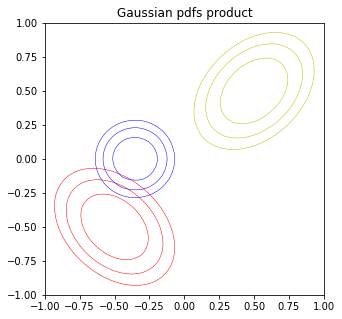

[-0.3535  0.    ]


In [169]:
plt.figure(figsize = (5,5))  

zero_mean = np.array([-0.5 , -0.5])
R = np.array([[1, -0.707],[0 ,1]])

mu_x = np.array([0.5 , 0.5])
sigma_x = np.array([[1, 0.707],[0 ,1]])
limit = 1
plot_2d_gauss(zero_mean, R, color='r', limits = [-limit,limit, -limit,limit], label = 'Gaussian A')
plot_2d_gauss(mu_x, sigma_x, color='y', limits = [-limit,limit, -limit,limit], label = 'Gaussian B')

mean, P = gauss_pdfs_mult(zero_mean, R, mu_x, sigma_x)
plot_2d_gauss(mean, P, color = 'b' , limits = [-limit,limit, -limit,limit], label = 'Gaussian C')
plt.title('Gaussian pdfs product')
plt.show()
print(mean)

### Applied to our problem

$\vec{Z_k} = H\vec{X_k} + \vec{V}$

$\large{p(X_k|Z_k) = \alpha p(Z_k|X_k)p(X_K)}$

$a = \mu_{x_k} = H^{-1}Z \quad A = H^{-1}R (H^{-1})^T \quad b=\hat{X}_{k|k-1} \quad  B = P_{k|k-1} $ 

$C = P_{k|k} \quad c=\hat{X}_{k|k}$

$P_{k|k} = \Sigma_{X_k}^{ud} = (H^TR^{-1}H + P_{k|k-1}^{-1})^{-1}$

$\hat{X}_{k|k} = \vec{\mu_x^{ud}} = P_{k|k}[H^TR^{-1}Z+P_{k|k-1}^{-1}{\hat{X}_{k|k-1}}]$

In [1]:
def update(H, R, Z, X_est_prior ,P_est_prior):
    H= np.array(H)
    A_1 = H.T.dot(np.linalg.inv(R)).dot(H)
    P_est_prior_inv = np.linalg.inv(P_est_prior)
    
    P_est = np.linalg.inv(A_1 + P_est_prior_inv)
    
    X_est = P_est.dot(H.T.dot(np.linalg.inv(R)).dot(Z) + P_est_prior_inv.dot(X_est_prior))
    
    return X_est, P_est

### Example: Position  is observed but speed is not observed

[ 0.  1.]
[[ 0.83333333  0.        ]
 [ 0.          4.99750125]]


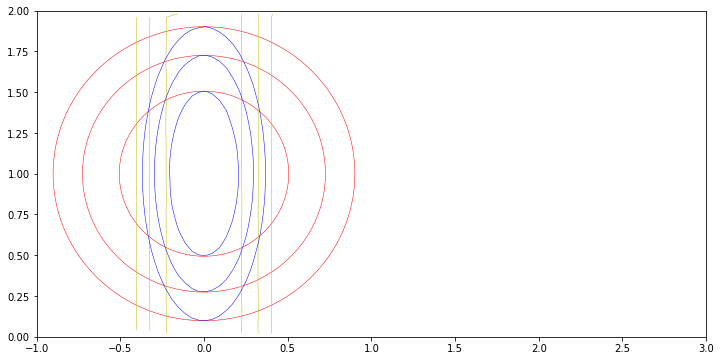

In [313]:
initial_speed_guess = 1
H = np.array([[1, 0],[0,1]])
# a priori estimates
X_est_prior = np.array([0 , initial_speed_guess])
P_est_prior = np.array([[5, 0],[0 ,5]])

# I quite know my position but not my speed then variance -> infinite
R = np.array([[1, 0],[0 ,10000]])
Z = H.dot(X_est_prior)
X_est_u, P_est_u = plot_update(H, R, Z, X_est_prior, P_est_prior, y_offset = initial_speed_guess, npts=4000)
print(X_est_u)
print(P_est_u)

## Prediction (Independent random vectors linear combination)

$E[A\vec{X} + \vec{Y}] = AE[\vec{X}]+E[\vec{Y}]$

$\Sigma_{AX+Y} = A\Sigma_{X}A^T + \Sigma_{Y}$

### Applied

$\vec{X_{k+1}} = F\vec{X_{k}} + \vec{W}$

$\hat{X}_{k+1} = F\hat{X}_{k}$

$P_{k+1} = FP_{k}F^T + Q$

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix} = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{W}$

$\hat{x_{k+1}} = \hat{x_{k}} + \Delta t \dot{X_k}$

In [183]:
def predict(F, mu_x, sigma_x, Q):
    X_est = F.dot(mu_x)
    P = F.dot(sigma_x).dot(F.T) + Q
    return X_est, P

## Initially I know my location but not my velocity

$X_0 = \begin{bmatrix}0\\ 0 \end{bmatrix} \quad$

$P_0 = \begin{bmatrix}0.1 & 0 \\ 0 & \infty \end{bmatrix} \quad$

$\begin{bmatrix}x_{k+1} \\ \dot{x_{k+1}} \end{bmatrix} = \begin{bmatrix}1 & \Delta{t} \\ 0 & 1 \end{bmatrix} \begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{W}$

### No error prediction
$\Sigma_w = Q = \begin{bmatrix}0 & 0 \\ 0 & 0 \end{bmatrix} \quad$

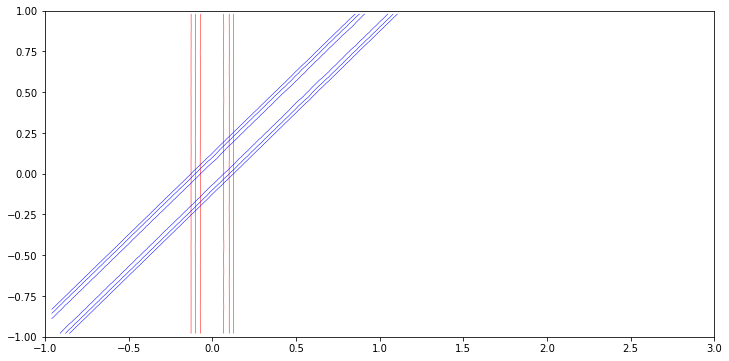

In [369]:
infty = 100000
initial_speed_guess = 0
X_est_u = np.array([0,0])
P_est_u = np.array([[0.1,0],[0,infty]])
F = np.array([[1, 1],[0,1]])
Q = np.array([[0, 0],[0,0]])

X_est_p_0, P_est_p_0  = plot_prediction(F, X_est_u, P_est_u, Q, y_offset = initial_speed_guess, npts = 4000)

In [363]:
# Now position and velocity are correlated:
print(P_est_p_0)

[[100001 100000]
 [100000 100000]]


### Error predicting position
$\Sigma_w = Q = \begin{bmatrix}1 & 0 \\ 0 & 0 \end{bmatrix} \quad$

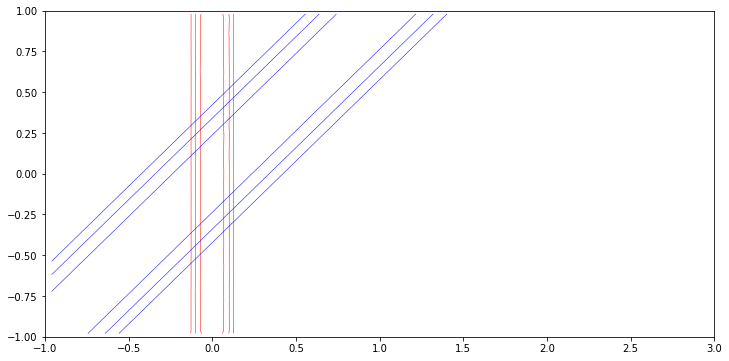

In [371]:
initial_speed_guess = 0
X_est_u = np.array([0,0])
P_est_u = np.array([[0.1,0],[0,infty]])
F = np.array([[1, 1],[0,1]])
Q = np.array([[1, 0],[0,0]])

X_est_p, P_est_p  = plot_prediction(F, X_est_u, P_est_u, Q, y_offset = initial_speed_guess, npts = 4000)

In [372]:
P_est_p

array([[ 100001.1,  100000. ],
       [ 100000. ,  100000. ]])

### Update

${Z_k} = \begin{bmatrix} 1 & 0 \end{bmatrix}\begin{bmatrix}x_{k} \\ \dot{x_{k}} \end{bmatrix} + \vec{V}$

$\Sigma_v = R = \sigma_v^2 $

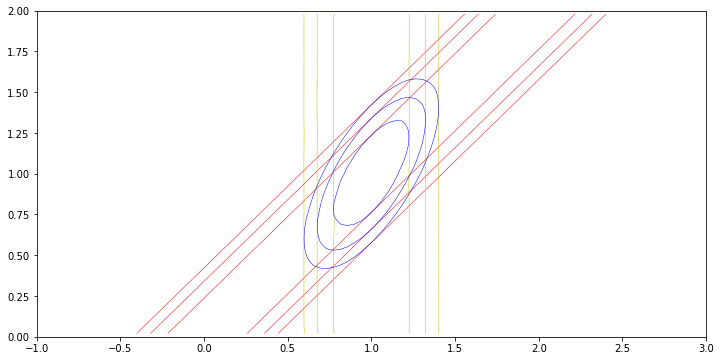

In [373]:
initial_speed_guess = 1
H = [1, 0]
R = [1]
Z = [1]
X_est_uu, P_est_uu = plot_update(H, R, Z, X_est_p, P_est_p, y_offset = initial_speed_guess, npts = 4000)

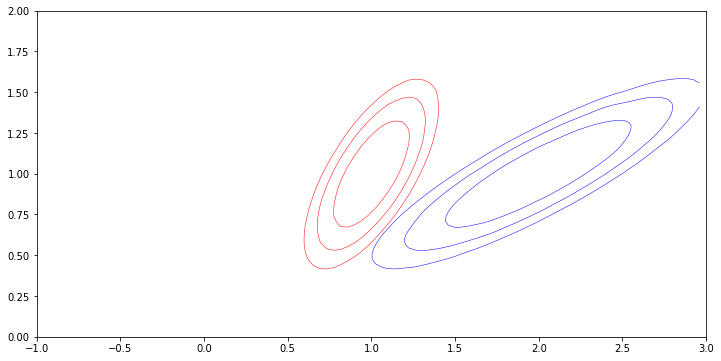

In [324]:
X_est_pp, P_est_pp  = plot_prediction(F, X_est_uu, P_est_uu, Q, y_offset = initial_speed_guess)

[ 0.99990002  0.99979004]


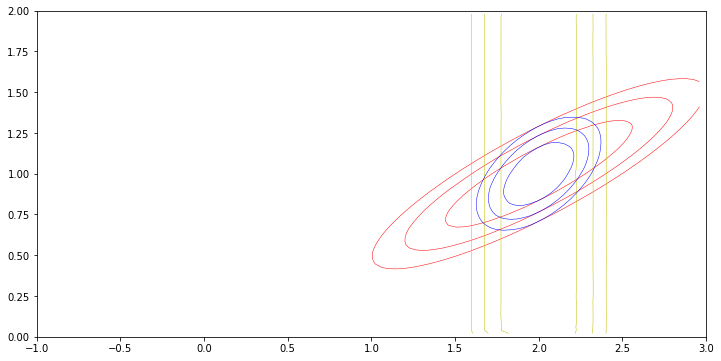

In [325]:
Z = [2]
mu_x_uuu, sigma_x_uuu = plot_update(H, R, Z, X_est_pp, P_est_pp, y_offset = initial_speed_guess, npts = 4000)
print(mu_x_uu)